# Analyzing GRB 080916C
![Alt text](https://astrobites.org/wp-content/uploads/2014/10/NASAGRBwhoa-1024x576.jpg)
*(NASA/Swift/Cruz deWilde)*

To demonstrate the capabilities and features of 3ML in, we will go through a time-integrated and time-resolved analysis. This example serves as a standard way to analyze Fermi-GBM data with 3ML as well as a template for how you can design your instrument's analysis pipeline with 3ML if you have similar data.

3ML provides utilities to reduce time series data to plugins in a *correct* and *statistically justified* way (e.g., background fitting of Poisson data is done with a Poisson likelihood). The approach is generic and can be extended. For more details, see the [time series documentation](https://threeml.readthedocs.io/en/stable/notebooks/Building_Plugins_from_TimeSeries.html).

In [1]:
import warnings

warnings.simplefilter("ignore")

In [2]:
%%capture
import matplotlib.pyplot as plt
import numpy as np

np.seterr(all="ignore")


from threeML import *
from threeML.io.package_data import get_path_of_data_file

In [3]:

silence_warnings()
%matplotlib inline
from jupyterthemes import jtplot

jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
set_threeML_style()

## Examining the catalog

As with Swift and Fermi-LAT, 3ML provides a simple interface to the on-line Fermi-GBM catalog. Let's get the information for GRB 080916C.

In [4]:
gbm_catalog = FermiGBMBurstCatalog()
gbm_catalog.query_sources("GRB080916009")

name,ra,dec,trigger_time,t90
object,float64,float64,float64,float64
GRB080916009,119.800,-56.600,54725.0088613,62.977


To aid in quickly replicating the catalog analysis, and thanks to the tireless efforts of the Fermi-GBM team, we have added the ability to extract the analysis parameters from the catalog as well as build an **astromodels** model with the best fit parameters baked in. Using this information, one can quickly run through the catalog an replicate the entire analysis with a script. Let's give it a try.

In [5]:
grb_info = gbm_catalog.get_detector_information()["GRB080916009"]

gbm_detectors = grb_info["detectors"]
source_interval = grb_info["source"]["fluence"]
background_interval = grb_info["background"]["full"]
best_fit_model = grb_info["best fit model"]["fluence"]
model = gbm_catalog.get_model(best_fit_model, "fluence")["GRB080916009"]

In [6]:
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (5):
--------------------

                                value min_value max_value            unit
GRB080916009...K             0.012255       0.0      None  keV-1 s-1 cm-2
GRB080916009...alpha        -1.130424      -1.5       2.0                
GRB080916009...break_energy  309.2031      10.0      None             keV
GRB080916009...break_scale        0.3       0.0      10.0                
GRB080916009...beta         -2.096931      -5.0      -1.6                

Fixed parameters (3):
(abridged. Use complete=True to see all fixed parameters)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

## Downloading the data
We provide a simple interface to download the Fermi-GBM data. Using the information from the catalog that we have extracted, we can download just the data from the detectors that were used for the catalog analysis. This will download the CSPEC, TTE and instrument response files from the on-line database.



In [7]:
dload = download_GBM_trigger_data("bn080916009", detectors=gbm_detectors)

Let's first examine the catalog fluence fit. Using the **TimeSeriesBuilder**, we can fit the background, set the source interval, and create a 3ML plugin for the analysis. We will loop through the detectors, set their appropriate channel selections, and ensure there are enough counts in each bin to make the [PGStat profile likelihood valid](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/).

* First we use the CSPEC data to fit the background using the background selections. We use CSPEC because it has a longer duration for fitting the background.
* The background is saved to an HDF5 file that stores the polynomial coefficients and selections which we can read in to the TTE file later.
* The light curve is plotted.
* The source selection from the catalog is set and **DispersionSpectrumLike** plugin is created.
* The plugin has the standard GBM channel selections for spectral analysis set.

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_03 background:   0%|          | 0/128 [00:00<?, ?it/s]

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_NAI_04 background:   0%|          | 0/128 [00:00<?, ?it/s]

Loading PHAII Spectra:   0%|          | 0/1859 [00:00<?, ?it/s]

Finding best polynomial Order:   0%|          | 0/5 [00:00<?, ?it/s]

Fitting GBM_BGO_00 background:   0%|          | 0/128 [00:00<?, ?it/s]

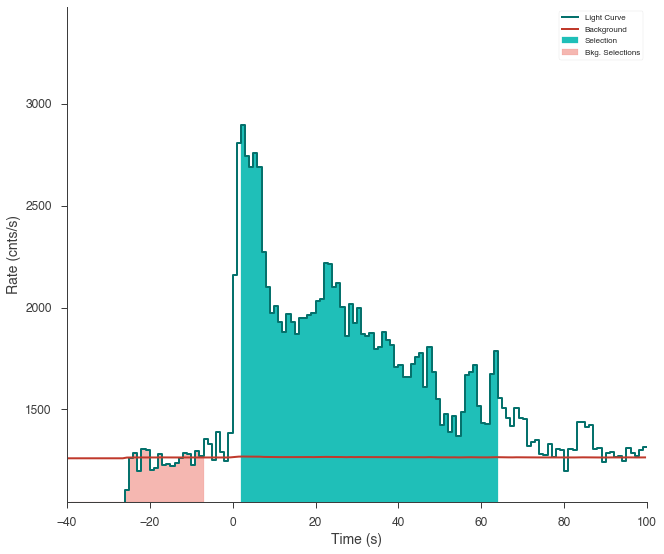

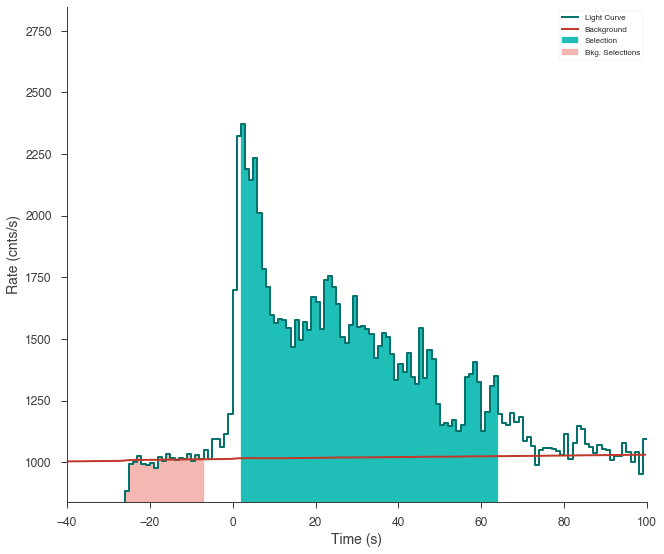

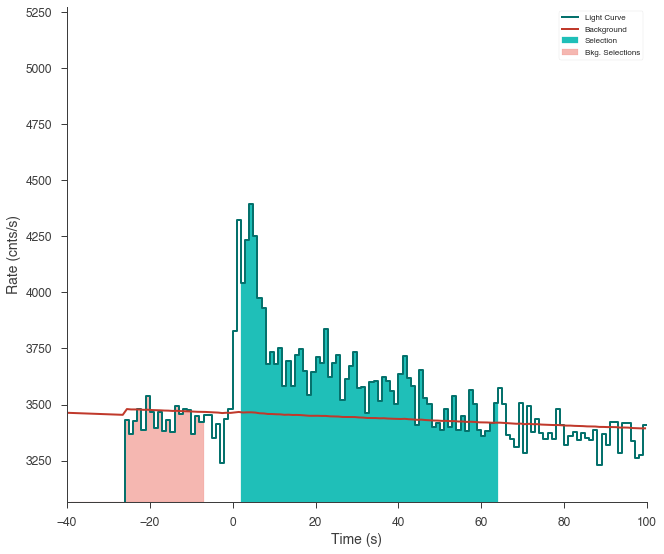

In [8]:
fluence_plugins = []
time_series = {}
for det in gbm_detectors:

    ts_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime(
        det, cspec_or_ctime_file=dload[det]["cspec"], rsp_file=dload[det]["rsp"]
    )

    ts_cspec.set_background_interval(*background_interval.split(","))
    ts_cspec.save_background(f"{det}_bkg.h5", overwrite=True)

    ts_tte = TimeSeriesBuilder.from_gbm_tte(
        det,
        tte_file=dload[det]["tte"],
        rsp_file=dload[det]["rsp"],
        restore_background=f"{det}_bkg.h5",
    )

    time_series[det] = ts_tte

    ts_tte.set_active_time_interval(source_interval)

    ts_tte.view_lightcurve(-40, 100)

    fluence_plugin = ts_tte.to_spectrumlike()

    if det.startswith("b"):

        fluence_plugin.set_active_measurements("250-30000")

    else:

        fluence_plugin.set_active_measurements("9-900")

    fluence_plugin.rebin_on_background(1.0)

    fluence_plugins.append(fluence_plugin)

## Setting up the fit
Let's see if we can reproduce the results from the catalog.

### Set priors for the model
We will fit the spectrum using Bayesian analysis, so we must set priors on the model parameters.


In [9]:
model.GRB080916009.spectrum.main.shape.alpha.prior = Truncated_gaussian(
    lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.beta.prior = Truncated_gaussian(
    lower_bound=-5, upper_bound=-1.6, mu=-2.25, sigma=0.5
)
model.GRB080916009.spectrum.main.shape.break_energy.prior = Log_normal(mu=2, sigma=1)
model.GRB080916009.spectrum.main.shape.break_energy.bounds = (None, None)
model.GRB080916009.spectrum.main.shape.K.prior = Log_uniform_prior(
    lower_bound=1e-3, upper_bound=1e1
)
model.GRB080916009.spectrum.main.shape.break_scale.prior = Log_uniform_prior(
    lower_bound=1e-4, upper_bound=10
)

### Clone the model and setup the Bayesian analysis class
Next, we clone the model we built from the catalog so that we can look at the results later and fit the cloned model. We pass this model and the **DataList** of the plugins to a **BayesianAnalysis** class and set the sampler to MultiNest.

In [10]:
new_model = clone_model(model)

bayes = BayesianAnalysis(new_model, DataList(*fluence_plugins))

# share spectrum gives a linear speed up when
# spectrumlike plugins have the same RSP input energies
bayes.set_sampler("multinest", share_spectrum=True)

### Examine at the catalog fitted model
We can quickly examine how well the catalog fit matches the data. There appears to be a discrepancy between the data and the model! Let's refit to see if we can fix it.

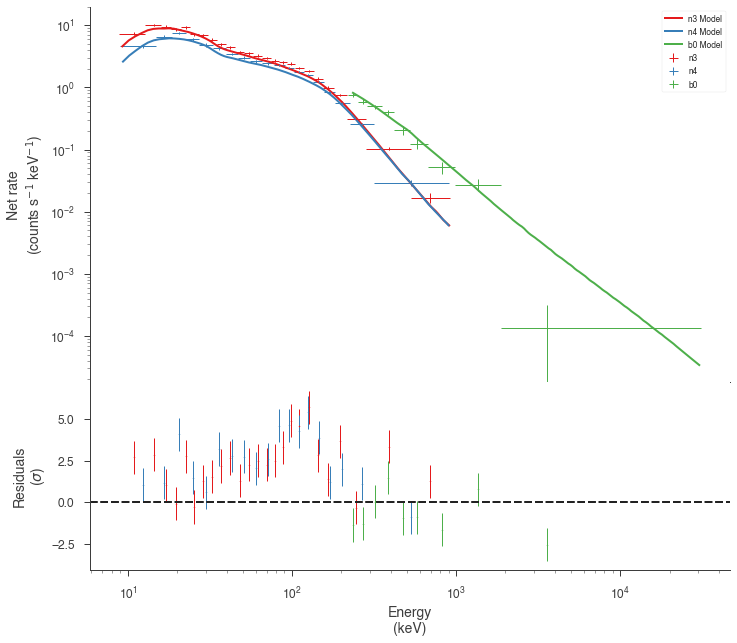

In [11]:
fig = display_spectrum_model_counts(bayes, min_rate=20, step=False)

### Run the sampler
We let MultiNest condition the model on the data

In [12]:
bayes.sampler.setup(n_live_points=400)
bayes.sample()

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
GRB080916009...K,(1.470 -0.017 +0.018) x 10^-2,1 / (cm2 keV s)
GRB080916009...alpha,-1.075 -0.017 +0.016,
GRB080916009...break_energy,(2.11 -0.21 +0.20) x 10^2,keV
GRB080916009...break_scale,(1.8 -0.9 +0.8) x 10^-1,
GRB080916009...beta,-2.09 +/- 0.07,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0,-1051.614710
n3,-1023.741139
n4,-1013.881117
total,-3089.236966



Values of statistical measures:



,statistical measures
AIC,6188.644386
BIC,6207.876597
DIC,6175.967607
PDIC,3.977915
log(Z),-1348.046124


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************
 ln(ev)=  -3103.9909097855184      +/-  0.22595296728364153     
 Total Likelihood Evaluations:        22062
 Sampling finished. Exiting MultiNest


Now our model seems to match much better with the data!

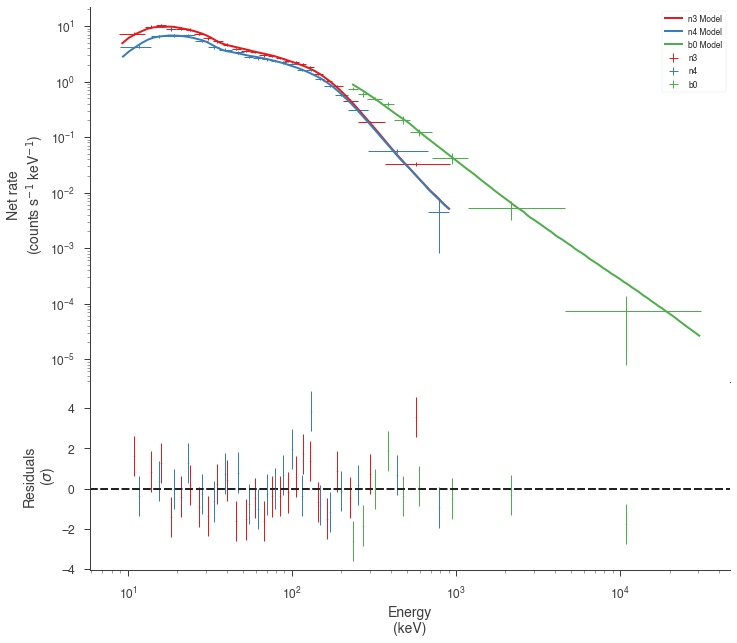

In [13]:
bayes.restore_median_fit()
fig = display_spectrum_model_counts(bayes, min_rate=20)

But how different are we from the catalog model? Let's plot our fit along with the catalog model. Luckily, 3ML can handle all the units for is

In [14]:
conversion = u.Unit("keV2/(cm2 s keV)").to("erg2/(cm2 s keV)")
energy_grid = np.logspace(1, 4, 100) * u.keV
vFv = (energy_grid ** 2 * model.get_point_source_fluxes(0, energy_grid)).to(
    "erg2/(cm2 s keV)"
)

processing Bayesian analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

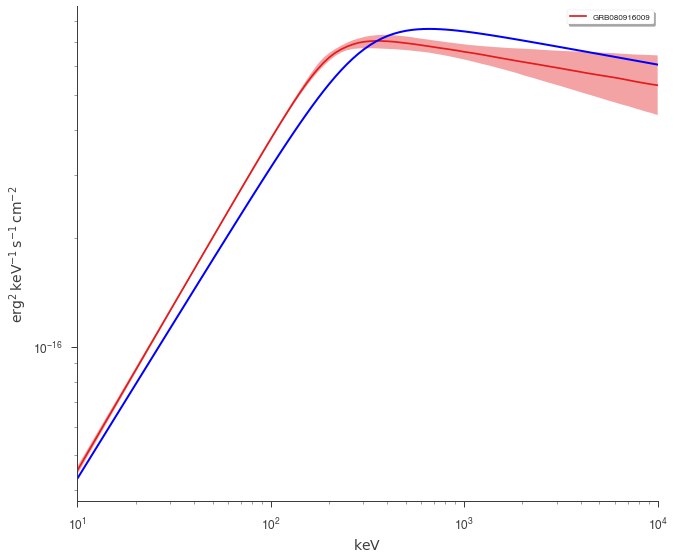

In [15]:
fig = plot_spectra(bayes.results, flux_unit="erg2/(cm2 s keV)")
ax = fig.get_axes()[0]
_ = ax.loglog(energy_grid, vFv, color="blue", label="catalog model")

## Time Resolved Analysis

Now that we have examined fluence fit, we can move to performing a time-resolved analysis.

### Selecting a temporal binning

We first get the brightest NaI detector and create time bins via the Bayesian blocks algorithm. We can use the fitted background to make sure that our intervals are chosen in an unbiased way.

In [16]:
n3 = time_series["n3"]

In [17]:
n3.create_time_bins(0, 60, method="bayesblocks", use_background=True, p0=0.2)

Sometimes, glitches in the GBM data cause spikes in the data that the Bayesian blocks algorithm detects as fast changes in the count rate. We will have to remove those intervals manually.

<div class="alert alert-info">

**Note:** In the future, 3ML will provide an automated method to remove these unwanted spikes.

</div>


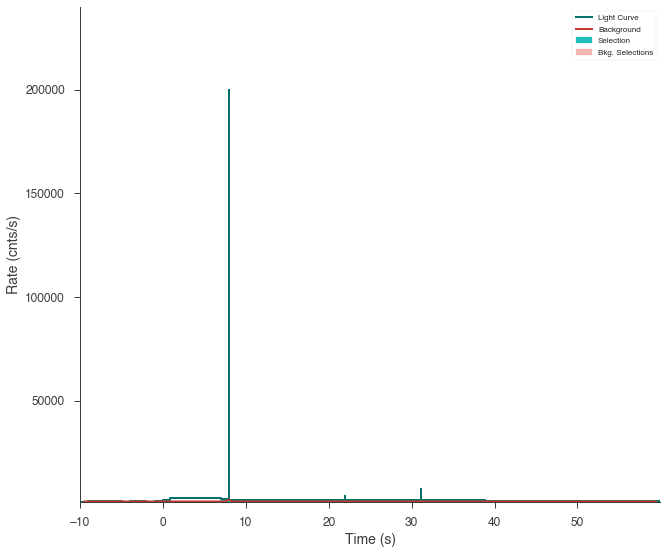

In [18]:
fig = n3.view_lightcurve(use_binner=True)

In [19]:
bad_bins = []
for i, w in enumerate(n3.bins.widths):

    if w < 5e-2:
        bad_bins.append(i)


edges = [n3.bins.starts[0]]

for i, b in enumerate(n3.bins):

    if i not in bad_bins:
        edges.append(b.stop)

starts = edges[:-1]
stops = edges[1:]


n3.create_time_bins(starts, stops, method="custom")

Now our light curve looks much more acceptable.

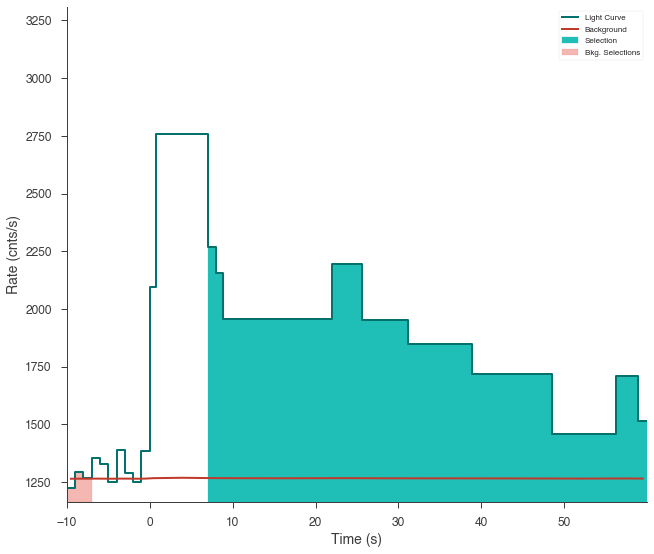

In [20]:
fig = n3.view_lightcurve(use_binner=True)

The time series objects can read time bins from each other, so we will map these time bins onto the other detectors' time series and create a list of time plugins for each detector and each time bin created above.

In [21]:
time_resolved_plugins = {}

for k, v in time_series.items():
    v.read_bins(n3)
    time_resolved_plugins[k] = v.to_spectrumlike(from_bins=True)

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

Creating plugins:   0%|          | 0/12 [00:00<?, ?it/s]

### Setting up the model
For the time-resolved analysis, we will fit the classic *Band* function to the data. We will set some principled priors.

In [22]:
band = Band()
band.alpha.prior = Truncated_gaussian(lower_bound=-1.5, upper_bound=1, mu=-1, sigma=0.5)
band.beta.prior = Truncated_gaussian(lower_bound=-5, upper_bound=-1.6, mu=-2, sigma=0.5)
band.xp.prior = Log_normal(mu=2, sigma=1)
band.xp.bounds = (0, None)
band.K.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e3)
ps = PointSource("grb", 0, 0, spectral_shape=band)
band_model = Model(ps)

### Perform the fits

One way to perform Bayesian spectral fits to all the intervals is to loop through each one. There can are many ways to do this, so find an analysis pattern that works for you.



In [23]:
models = []
results = []
analysis = []
for interval in range(12):

    # clone the model above so that we have a separate model
    # for each fit

    this_model = clone_model(band_model)

    # for each detector set up the plugin
    # for this time interval

    this_data_list = []
    for k, v in time_resolved_plugins.items():

        pi = v[interval]

        if k.startswith("b"):
            pi.set_active_measurements("250-30000")
        else:
            pi.set_active_measurements("9-900")

        pi.rebin_on_background(1.0)

        this_data_list.append(pi)

    # create a data list

    dlist = DataList(*this_data_list)

    # set up the sampler and fit

    bayes = BayesianAnalysis(this_model, dlist)

    # get some speed with share spectrum
    bayes.set_sampler("multinest", share_spectrum=True)
    bayes.sampler.setup(n_live_points=500)
    bayes.sample()

    # at this stage we coudl also
    # save the analysis result to
    # disk but we will simply hold
    # onto them in memory

    analysis.append(bayes)

  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.8 +/- 0.5) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-5.3 -1.0 +1.1) x 10^-1,
grb.spectrum.main.Band.xp,(2.9 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-1.98 -0.08 +0.10,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval0,-280.530551
n3_interval0,-245.058575
n4_interval0,-261.433501
total,-787.022626



Values of statistical measures:



,statistical measures
AIC,1582.158567
BIC,1597.567384
DIC,1560.048601
PDIC,1.889054
log(Z),-343.795966


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(4.09 +/- 0.05) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.68 -0.07 +0.05) x 10^-1,
grb.spectrum.main.Band.xp,(6.22 -0.22 +0.21) x 10^2,keV
grb.spectrum.main.Band.beta,-2.154 -0.027 +0.04,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval1,-665.019760
n3_interval1,-634.795829
n4_interval1,-638.415173
total,-1938.230762



Values of statistical measures:



,statistical measures
AIC,3884.574839
BIC,3899.983656
DIC,3857.046162
PDIC,2.425068
log(Z),-845.725614


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.55 -0.23 +0.34) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.05 -0.07 +0.10,
grb.spectrum.main.Band.xp,(6.0 -1.8 +1.6) x 10^2,keV
grb.spectrum.main.Band.beta,-2.08 -0.08 +0.10,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval2,-318.357918
n3_interval2,-282.751078
n4_interval2,-305.375612
total,-906.484608



Values of statistical measures:



,statistical measures
AIC,1821.082531
BIC,1836.491348
DIC,1796.188528
PDIC,3.044124
log(Z),-395.292923


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.87 -0.34 +0.30) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.4 +/- 0.8) x 10^-1,
grb.spectrum.main.Band.xp,(3.5 -0.6 +0.7) x 10^2,keV
grb.spectrum.main.Band.beta,-2.16 +/- 0.14,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval3,-292.046297
n3_interval3,-237.231673
n4_interval3,-257.068541
total,-786.346511



Values of statistical measures:



,statistical measures
AIC,1580.806337
BIC,1596.215155
DIC,1558.885674
PDIC,2.388810
log(Z),-343.062416


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.07 -0.11 +0.09) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.80 -0.35 +0.31) x 10^-1,
grb.spectrum.main.Band.xp,(3.85 -0.34 +0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-1.97 -0.08 +0.06,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval4,-773.449893
n3_interval4,-751.728695
n4_interval4,-740.921829
total,-2266.100416



Values of statistical measures:



,statistical measures
AIC,4540.314146
BIC,4555.722964
DIC,4520.142068
PDIC,3.258099
log(Z),-988.117694


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.96 -0.21 +0.20) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.7 +/- 0.6) x 10^-1,
grb.spectrum.main.Band.xp,(3.7 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-1.96 +/- 0.04,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval5,-532.386646
n3_interval5,-517.445737
n4_interval5,-522.988038
total,-1572.820421



Values of statistical measures:



,statistical measures
AIC,3153.754157
BIC,3169.162974
DIC,3133.156420
PDIC,2.854319
log(Z),-686.192157


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.04 +/- 0.15) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-9.9 -0.7 +0.6) x 10^-1,
grb.spectrum.main.Band.xp,(4.0 -0.6 +0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.50 +/- 0.26,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval6,-606.953300
n3_interval6,-577.943789
n4_interval6,-570.867762
total,-1755.764851



Values of statistical measures:



,statistical measures
AIC,3519.643016
BIC,3535.051834
DIC,3497.735660
PDIC,3.342755
log(Z),-764.760406


  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.52 -0.07 +0.09) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,-1.194 -0.025 +0.030,
grb.spectrum.main.Band.xp,(4.5 +/- 0.8) x 10^2,keV
grb.spectrum.main.Band.beta,-1.947 -0.025 +0.022,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval7,-666.035819
n3_interval7,-641.710451
n4_interval7,-647.684514
total,-1955.430783



Values of statistical measures:



,statistical measures
AIC,3918.974881
BIC,3934.383699
DIC,3895.132139
PDIC,3.054977
log(Z),-853.458696


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.59 -0.12 +0.13) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.3 +/- 0.7) x 10^-1,
grb.spectrum.main.Band.xp,(3.5 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.56 -0.23 +0.27,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval8,-696.998757
n3_interval8,-693.602096
n4_interval8,-660.848187
total,-2051.449040



Values of statistical measures:



,statistical measures
AIC,4111.011394
BIC,4126.420212
DIC,4089.742743
PDIC,2.681637
log(Z),-893.499900


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(1.2 -0.5 +0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-8.6 +/- 1.8) x 10^-1,
grb.spectrum.main.Band.xp,(1.3 +/- 0.4) x 10^2,keV
grb.spectrum.main.Band.beta,-2.14 +/- 0.32,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval9,-647.015080
n3_interval9,-614.962021
n4_interval9,-613.785968
total,-1875.763069



Values of statistical measures:



,statistical measures
AIC,3759.639452
BIC,3775.048269
DIC,3738.465210
PDIC,-6.885511
log(Z),-817.069999


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(2.2 -0.5 +0.4) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-7.2 +/- 1.4) x 10^-1,
grb.spectrum.main.Band.xp,(2.3 +/- 0.5) x 10^2,keV
grb.spectrum.main.Band.beta,-2.26 -0.35 +0.34,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval10,-457.188985
n3_interval10,-433.934532
n4_interval10,-429.069074
total,-1320.192591



Values of statistical measures:



,statistical measures
AIC,2648.498496
BIC,2663.907313
DIC,2629.593156
PDIC,0.721005
log(Z),-575.258289


  analysing data from chains/fit-.txt


Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
grb.spectrum.main.Band.K,(3.6 -1.7 +1.6) x 10^-2,1 / (cm2 keV s)
grb.spectrum.main.Band.alpha,(-4.4 -3.0 +2.6) x 10^-1,
grb.spectrum.main.Band.xp,(1.24 -0.29 +0.26) x 10^2,keV
grb.spectrum.main.Band.beta,-2.15 -0.18 +0.23,



Values of -log(posterior) at the minimum:



,-log(posterior)
b0_interval11,-289.594857
n3_interval11,-269.159234
n4_interval11,-252.373898
total,-811.127990



Values of statistical measures:



,statistical measures
AIC,1630.369294
BIC,1645.778111
DIC,1610.915779
PDIC,-1.638212
log(Z),-353.675120


 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(ev)=  -791.61946721957281      +/-  0.18507046814776237     
 Total Likelihood Evaluations:        16477
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1947.3551906370674      +/-  0.22900442741229421     
 Total Likelihood Evaluations:        22171
 Sampling finished. Exiting MultiNest
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  500
 dimensionality =    4
 *****************************************************
 ln(

### Examine the fits
Now we can look at the fits in count space to make sure they are ok.

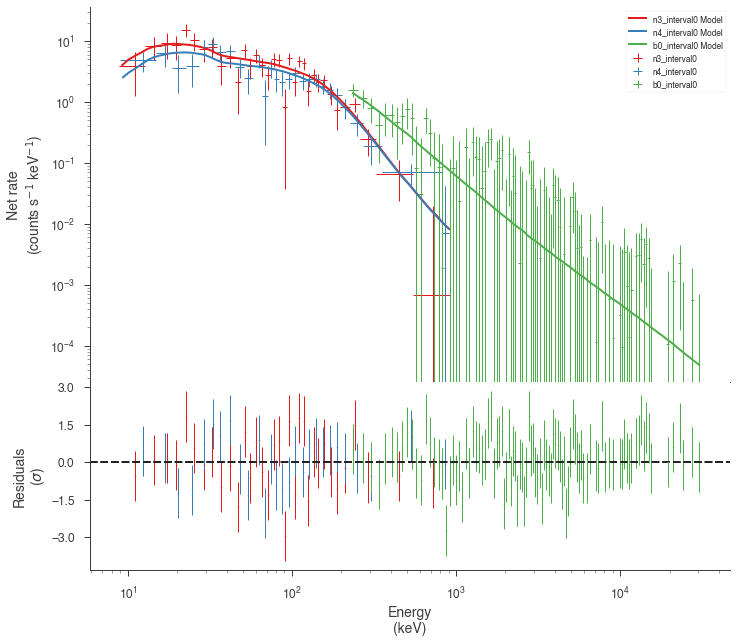

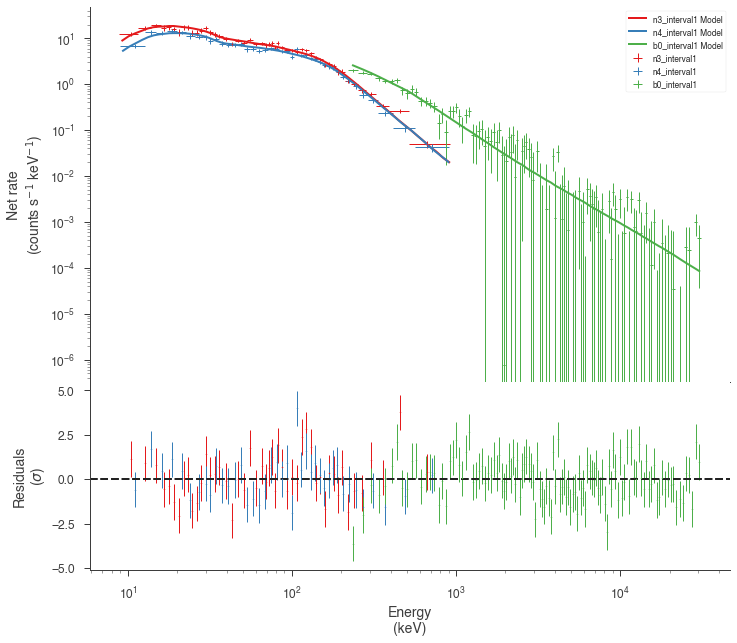

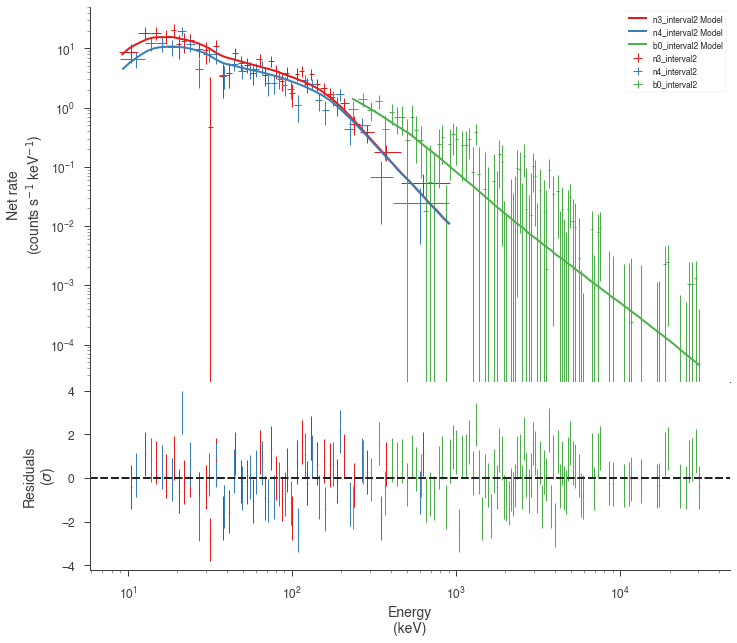

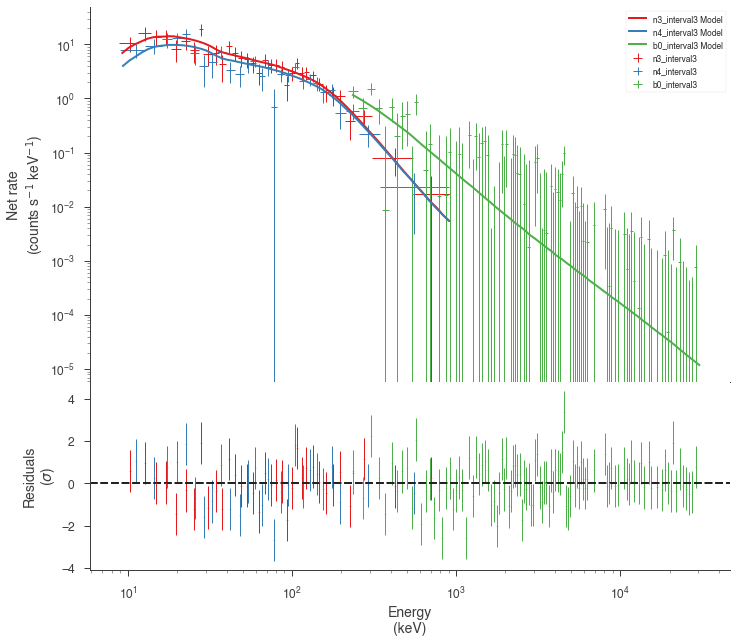

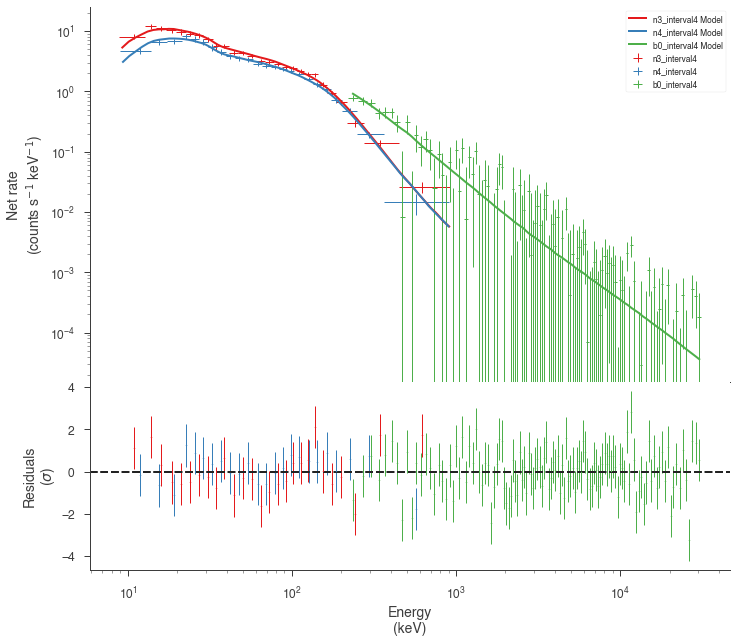

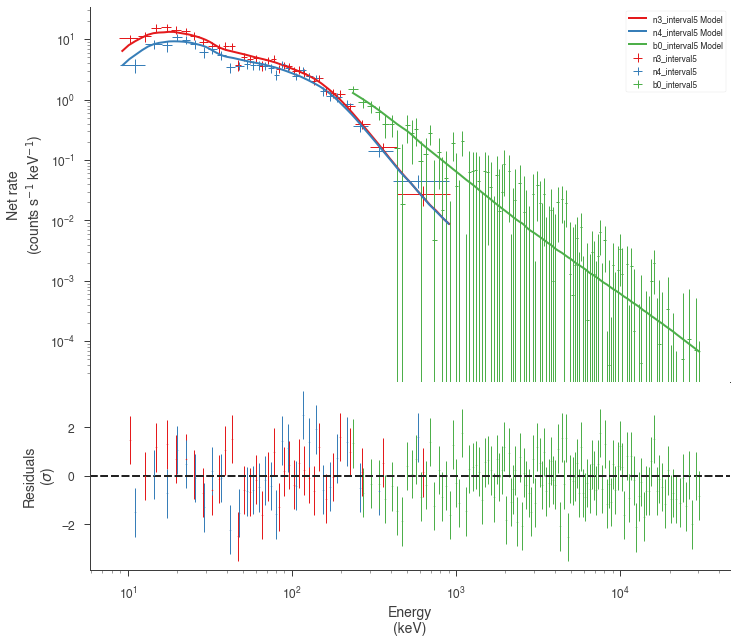

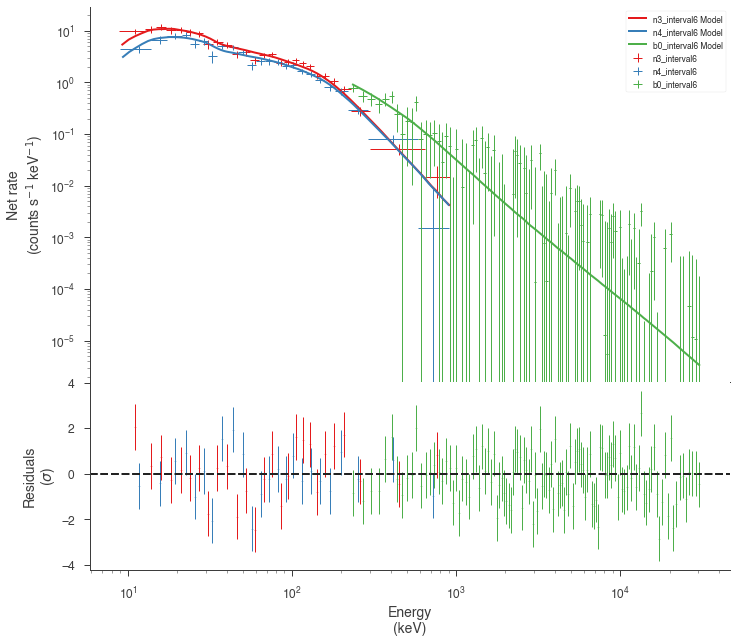

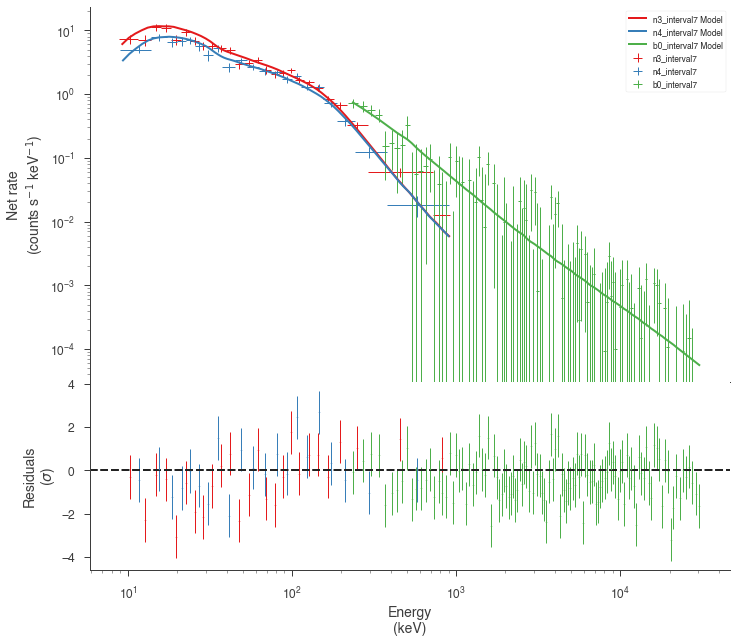

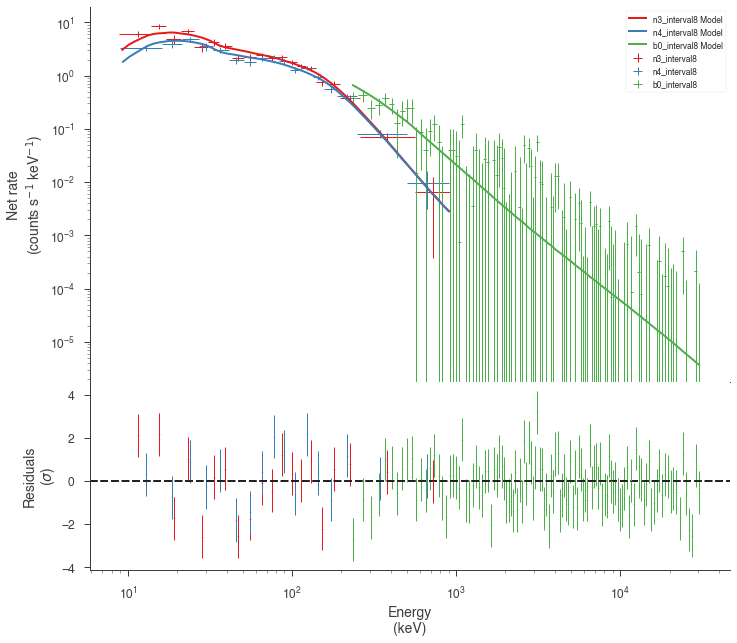

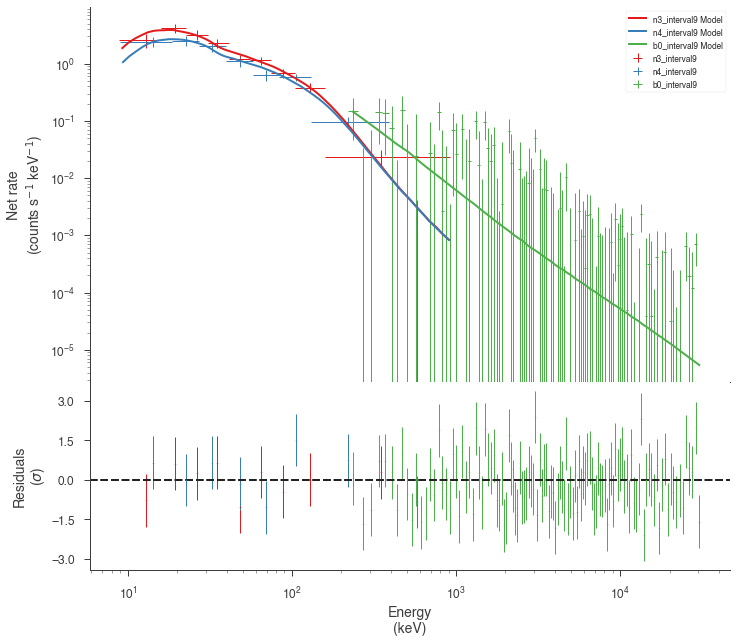

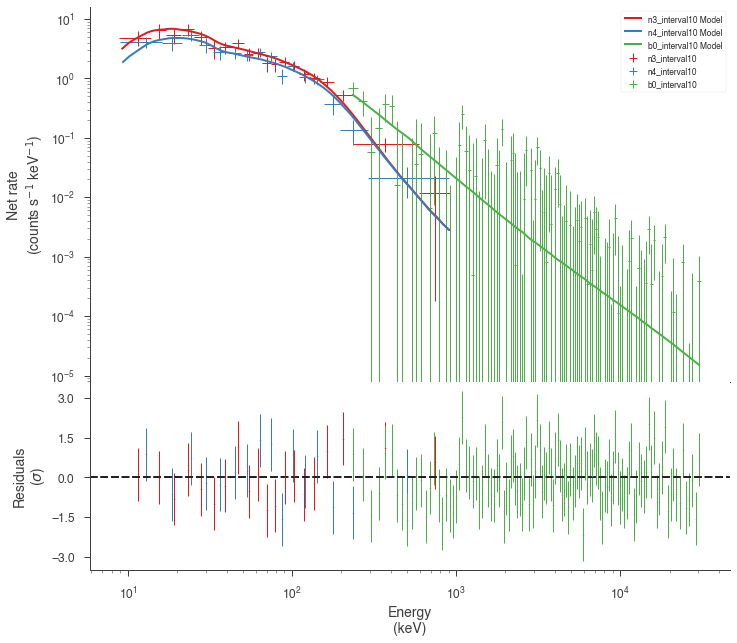

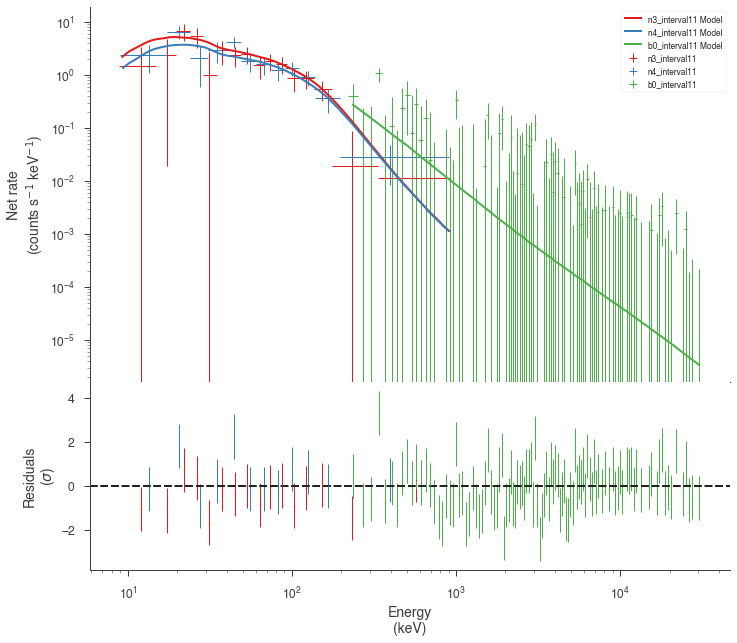

In [24]:
for a in analysis:
    a.restore_median_fit()
    _ = display_spectrum_model_counts(a, min_rate=[20, 20, -99], step=False)

Finally, we can plot the models together to see how the spectra evolve with time.

processing Bayesian analyses:   0%|          | 0/12 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

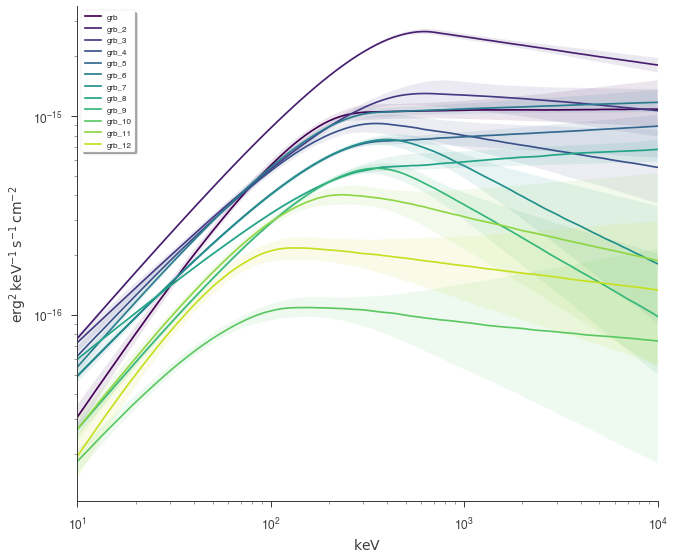

In [25]:
fig = plot_spectra(
    *[a.results for a in analysis[::1]],
    flux_unit="erg2/(cm2 s keV)",
    fit_cmap="viridis",
    contour_cmap="viridis",
    contour_style_kwargs=dict(alpha=0.1),
)

This example can serve as a template for performing analysis on GBM data. However, as 3ML provides an abstract interface and modular building blocks, similar analysis pipelines can be built for any time series data.